# Isolation Forest for Anomaly Detection: An In-Depth Guide

**Author:** Sayan De

**Date:** 04/02/2025  

## Objective
- To understand the theoretical foundations of the Isolation Forest algorithm for anomaly detection.
- To explore and preprocess the UNSW-NB15 dataset.
- To implement and evaluate an Isolation Forest model.
- To discuss advantages, limitations, and performance metrics with detailed interpretation.

---

## Table of Contents
1. [Introduction and Theoretical Background](#introduction)
2. [Dataset Overview](#dataset-overview)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Data Preprocessing](#preprocessing)
5. [Isolation Forest: Algorithm and Mathematical Intuition](#if-algorithm)
6. [Model Implementation](#model-implementation)
7. [Performance Evaluation and Metrics](#evaluation)
8. [Key Insights and Conclusion](#conclusion)


## 1. Introduction and Theoretical Background
Isolation Forest is a tree-based ensemble method for anomaly detection. Unlike distance-based or density-based techniques, Isolation Forest isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the feature.

### Key Concepts and Steps:
1. **Isolation Principle:**  
   - Anomalies are "few and different" compared to normal instances.
   - They are easier to isolate because they have attribute values that are significantly different.
  
2. **Algorithm Steps:**
   - **Random Partitioning:**  
     For each tree in the ensemble, randomly select a feature and a random split value between the feature's minimum and maximum.
   - **Path Length:**  
     The number of splits required to isolate a sample is its path length. Anomalies typically have shorter paths.
   - **Anomaly Score:**  
     The anomaly score for a data point is based on the average path length over all trees. A lower average path length indicates an anomaly.
  
3. **Mathematical Intuition:**  
   - For a dataset with \( n \) points, the average path length \( c(n) \) is approximated by:
     \[
     c(n) \approx 2H(n-1) - \left(\frac{2(n-1)}{n}\right)
     \]
     where \( H(i) \) is the \( i \)-th harmonic number.
   - The anomaly score \( s(x, n) \) for a point \( x \) is computed as:
     \[
     s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
     \]
     where \( E(h(x)) \) is the average path length of \( x \) over all trees. Scores close to 1 indicate anomalies, while scores significantly lower than 0.5 indicate normal instances.
  
4. **Advantages:**
   - Efficient for high-dimensional data.
   - No assumptions about the distribution of data.
   - Scalable to large datasets.
  
5. **Limitations:**
   - Sensitivity to the contamination parameter (expected proportion of anomalies).
   - May struggle if anomalies are not clearly separable in the feature space.

This notebook will apply the Isolation Forest algorithm on the popular UNSW-NB15 dataset for network intrusion detection.


In [15]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Ensure all columns are visible when printing the DataFrame
pd.set_option('display.max_columns', None)

print("Libraries imported successfully.")


Libraries imported successfully.


### Interpretation:
This cell imports essential Python libraries:
- **pandas & numpy:** For data manipulation and numerical operations.
- **matplotlib & seaborn:** For generating detailed visualizations.
- **IsolationForest:** The core model used for unsupervised anomaly detection.
- **StandardScaler:** To standardize feature scales.
- **classification_report & confusion_matrix:** For performance evaluation when ground truth is available.

The configuration to display all DataFrame columns aids in a complete data overview.


In [16]:
# Load the UNSW-NB15 dataset
path = "/content/UNSW_NB15_training-set.csv"
data = pd.read_csv(path)

# Display the first 5 rows to verify the content
data.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


### Interpretation:
In this step:
- The UNSW-NB15 training dataset is loaded from an external URL.
- A try-except block ensures that errors during loading are captured.
- The first few rows of the dataset are displayed to confirm the dataset’s structure and content.
  
This dataset is widely used in intrusion detection research and contains a mix of network traffic data with various features.


In [17]:
# Dataset Overview: Shape, Info, and Summary Statistics

print("Dataset Shape:", data.shape)

print("\nData Information:")
data.info()

print("\nSummary Statistics:")
data.describe()


Dataset Shape: (82332, 45)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.00000,8.233200e+04,8.233200e+04,82332.00000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,4.753692,6.308556,755.394301,121.701284,6.363075e+03,535.180430,133.45908,1.084642e+09,1.073465e+09,128.28662,0.055925,0.029256,0.026669,139.528604,116.275069,0.094277,1.595372e+03,9.546604,1.369273,5.744923,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,64.649620,55.708021,6182.615732,1292.378499,5.672402e+04,3635.305383,127.35700,1.390860e+09,1.381996e+09,127.49137,0.116022,0.070854,0.055094,208.472063,244.600271,0.542922,3.806697e+04,11.090289,1.067188,8.418112,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,1.000000,0.000000,0.557929,0.010000,1.762392e+01,0.000000,255.00000,2.788886e+07,2.856975e+07,255.00000,0.000551,0.000441,0.000080,65.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,3.000000,2.000000,63.409444,63.136369,3.219332e+03,128.459914,255.00000,2.171310e+09,2.144205e+09,255.00000,0.105541,0.052596,0.048816,100.000000,87.000000,0.000000,0.000000e+00,11.000000,2.000000,6.000000,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,60009.992000,57739.240000,1.483831e+06,463199.240100,255.00000,4.294950e+09,4.294881e+09,255.00000,3.821465,3.226788,2.928778,1504.000000,1500.000000,131.000000,5.242880e+06,63.000000,6.000000,59.000000,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


### Interpretation:
This cell provides a comprehensive overview of the dataset:
- **Shape:** Indicates the total number of rows and columns.
- **Data Information:** Shows data types, non-null counts, and memory usage to detect missing values or irregularities.
- **Summary Statistics:** Offers insights into numerical features (mean, standard deviation, min/max, quartiles) which are crucial for later scaling and model training.
  
Understanding these aspects is essential to appropriately prepare and pre-process the data.


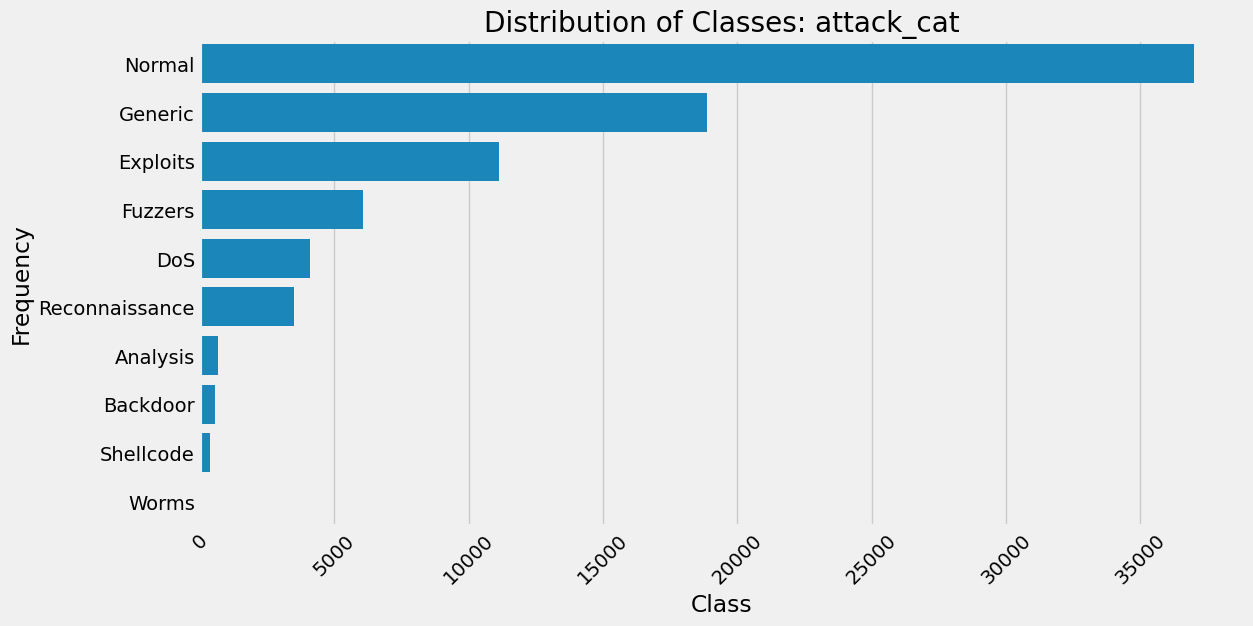

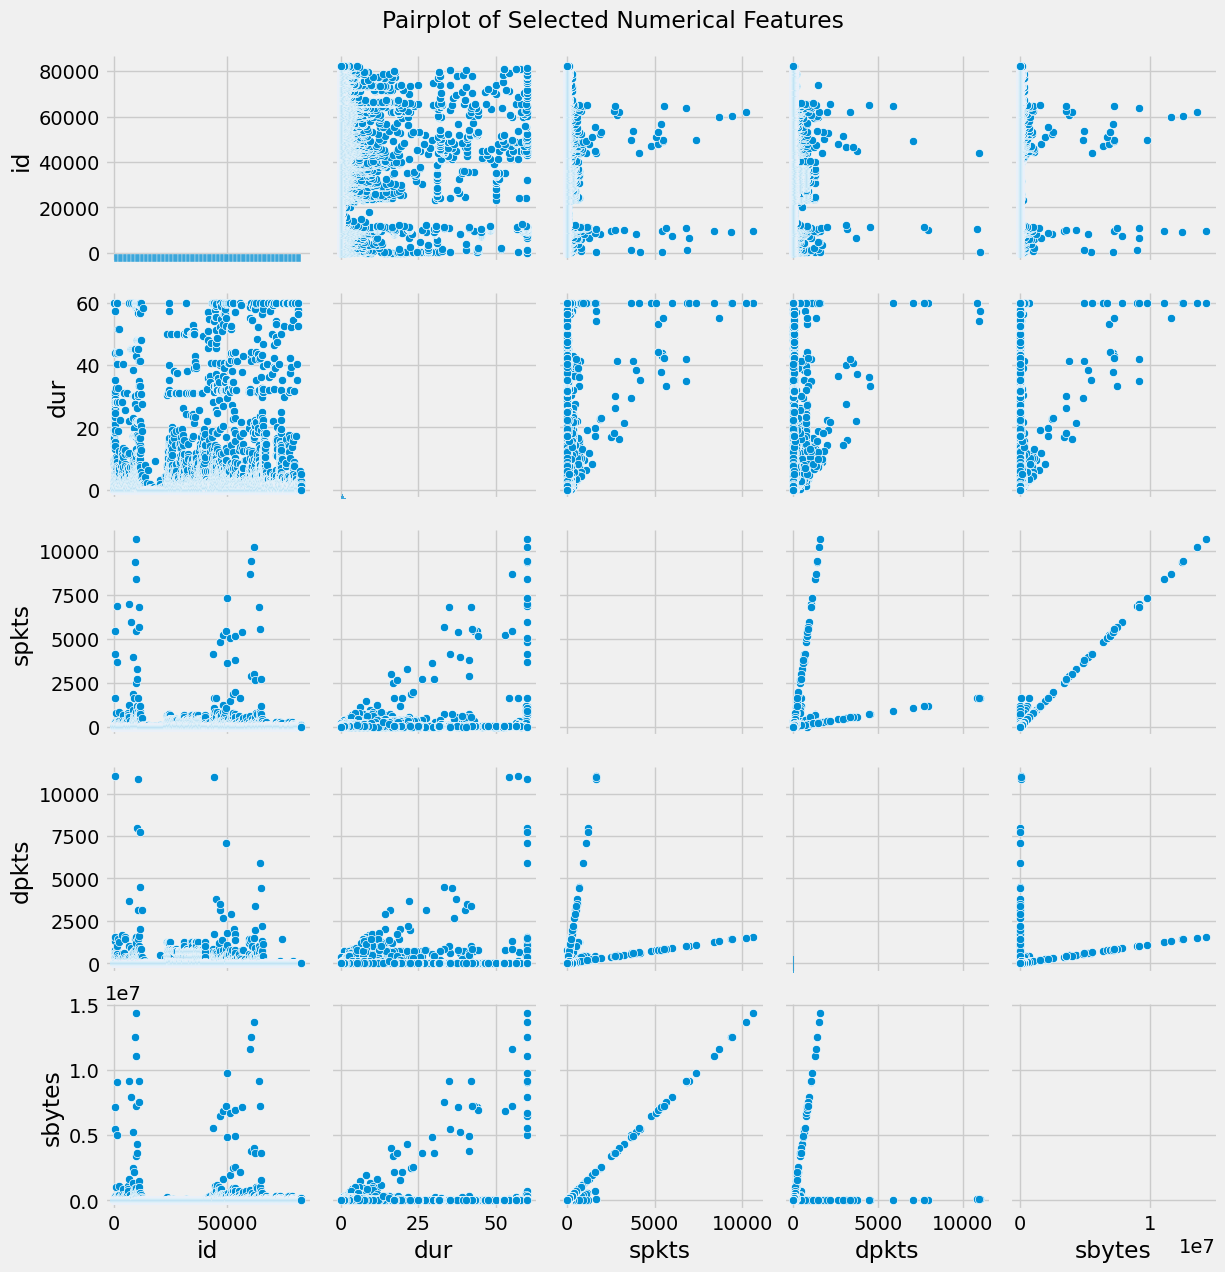

In [7]:
# Exploratory Data Analysis (EDA)

# Check for any target labels in the dataset.
# In UNSW-NB15, there might be a column such as 'attack_cat' or 'label'.
# For the purpose of unsupervised detection, we will not use these labels during training.

if 'attack_cat' in data.columns:
    target_col = 'attack_cat'
elif 'label' in data.columns:
    target_col = 'label'
else:
    target_col = None

if target_col:
    plt.figure(figsize=(12, 6))
    sns.countplot(data[target_col], order=data[target_col].value_counts().index)
    plt.title(f"Distribution of Classes: {target_col}")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No explicit target column found for class distribution.")

# Visualize relationships between a subset of numerical features
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
selected_features = numerical_features[:5]  # Selecting first 5 numerical features for visualization

sns.pairplot(data[selected_features])
plt.suptitle("Pairplot of Selected Numerical Features", y=1.02)
plt.show()


### Interpretation:
In this EDA section:
- **Class Distribution:**  
  - We check for a target column (e.g., `attack_cat` or `label`) and visualize its distribution using a count plot.  
  - This helps in understanding the imbalance between normal and anomalous classes, though the Isolation Forest will operate unsupervised.
- **Pairplot:**  
  - A pairplot is created for a subset of numerical features to observe potential correlations and patterns.
  
Visual insights from these plots guide decisions during data preprocessing and later evaluation.


In [18]:
# Data Preprocessing: Feature Selection and Scaling

# For unsupervised anomaly detection, we use only numerical features.
numerical_data = data.select_dtypes(include=[np.number])

# Standardize features to have zero mean and unit variance.
scaler = StandardScaler()
scaled_array = scaler.fit_transform(numerical_data)

# Convert the scaled array back to a DataFrame.
scaled_data = pd.DataFrame(scaled_array, columns=numerical_data.columns)

print("Data has been scaled and is ready for model training.")


Data has been scaled and is ready for model training.


### Interpretation:
This preprocessing step involves:
- **Feature Selection:**  
  - Filtering the dataset to retain only numerical features, as these are directly suitable for Isolation Forest.
- **Standardization:**  
  - Scaling the features using `StandardScaler` ensures that each attribute contributes equally. This step is crucial because Isolation Forest uses random splits, and features with larger scales could dominate the isolation process.
- **Conversion to DataFrame:**  
  - For easier data manipulation and integration with subsequent analysis steps.
  
After these operations, the data is appropriately preprocessed for model training.


In [19]:
# Isolation Forest Model Implementation

# Initialize the Isolation Forest model.
# Key parameters:
#   - n_estimators: Number of trees in the ensemble.
#   - contamination: The expected proportion of anomalies in the dataset.
#   - random_state: Ensures reproducibility.
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Train the model on the scaled dataset.
model.fit(scaled_data)

# Generate predictions: 1 indicates normal, -1 indicates an anomaly.
predictions = model.predict(scaled_data)

# Append the anomaly prediction to the DataFrame for further analysis.
scaled_data['anomaly'] = predictions

print("Isolation Forest model has been trained and predictions are available.")


Isolation Forest model has been trained and predictions are available.


### Interpretation:
Here we implement the Isolation Forest model:
- **Model Initialization:**  
  - We specify 100 trees (`n_estimators=100`) to form an ensemble.  
  - The `contamination` parameter is set to 0.1, meaning that approximately 10% of the data is expected to be anomalous. Adjust this value based on domain knowledge.
- **Model Training:**  
  - The Isolation Forest is fitted on the preprocessed, scaled data.
- **Prediction:**  
  - The model labels each data point with 1 (normal) or -1 (anomaly).  
  - These predictions are added as a new column to the DataFrame, which can later be used for visualization and performance evaluation.
  
The model now encapsulates the isolation principle, where anomalies tend to have shorter path lengths in the isolation trees.


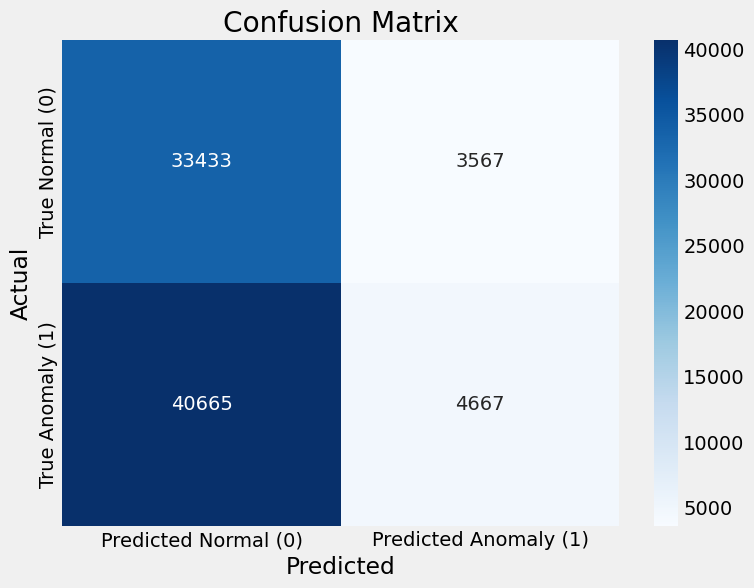

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.90      0.60     37000
           1       0.57      0.10      0.17     45332

    accuracy                           0.46     82332
   macro avg       0.51      0.50      0.39     82332
weighted avg       0.51      0.46      0.37     82332



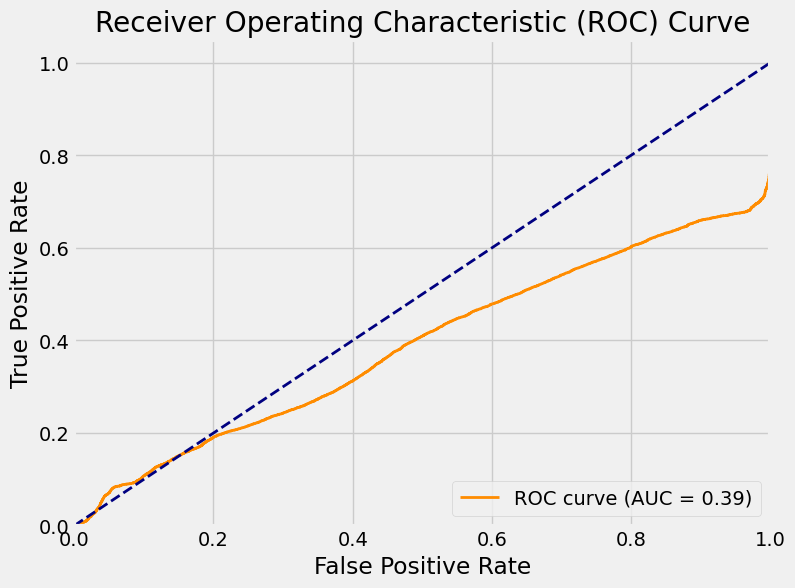

In [21]:
from sklearn.metrics import roc_curve, auc

# Performance Evaluation and Metrics

if target_col and target_col in data.columns:
    # Extract true labels
    true_labels = data[target_col].copy()

    # Map true labels: consider 'Normal' or 'benign' as normal (0), and all other labels as anomalies (1)
    if true_labels.dtype == 'object':
        true_labels = true_labels.apply(lambda x: 0 if x.lower() in ['normal', 'benign'] else 1)

    # Convert Isolation Forest predictions to binary format: 1 (normal) -> 0 and -1 (anomaly) -> 1.
    binary_predictions = np.where(predictions == 1, 0, 1)

    # Compute confusion matrix and display it as a heatmap
    cm = confusion_matrix(true_labels, binary_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal (0)', 'Predicted Anomaly (1)'],
                yticklabels=['True Normal (0)', 'True Anomaly (1)'])
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Display classification report
    cr = classification_report(true_labels, binary_predictions)
    print("Classification Report:")
    print(cr)

    # Compute ROC curve and AUC using the decision function scores from the model.
    # Note: In Isolation Forest, a higher decision function score indicates a more normal instance.
    scores = model.decision_function(scaled_data.drop("anomaly", axis=1))
    fpr, tpr, thresholds = roc_curve(true_labels, scores * -1)  # multiply by -1 to invert scores (anomaly=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

else:
    print("True labels are not available for performance evaluation.")


- **High True Negatives:** A large number of normal instances were correctly identified as normal, indicating the model effectively recognizes non-anomalous data.
- **High False Negatives:** A significant number of anomalies were misclassified as normal, which is concerning for detecting potential threats or unusual behavior.
- **Low True Positives:** The relatively small number of correctly identified anomalies compared to the total actual anomalies results in low sensitivity (recall).
- **Moderate False Positives:** Some normal instances were incorrectly flagged as anomalies, which may lead to false alarms but are less critical than missing anomalies.
- **Low Recall:** The model's ability to detect anomalies is poor, as it misses a large portion of them, which is a critical drawback in applications where detecting anomalies is essential.
- **Overall Performance Concern:** The imbalance between correctly identified normals and misclassified anomalies suggests that while the model performs well on normal data, its effectiveness in capturing anomalies is inadequate, calling for further tuning or alternative approaches.

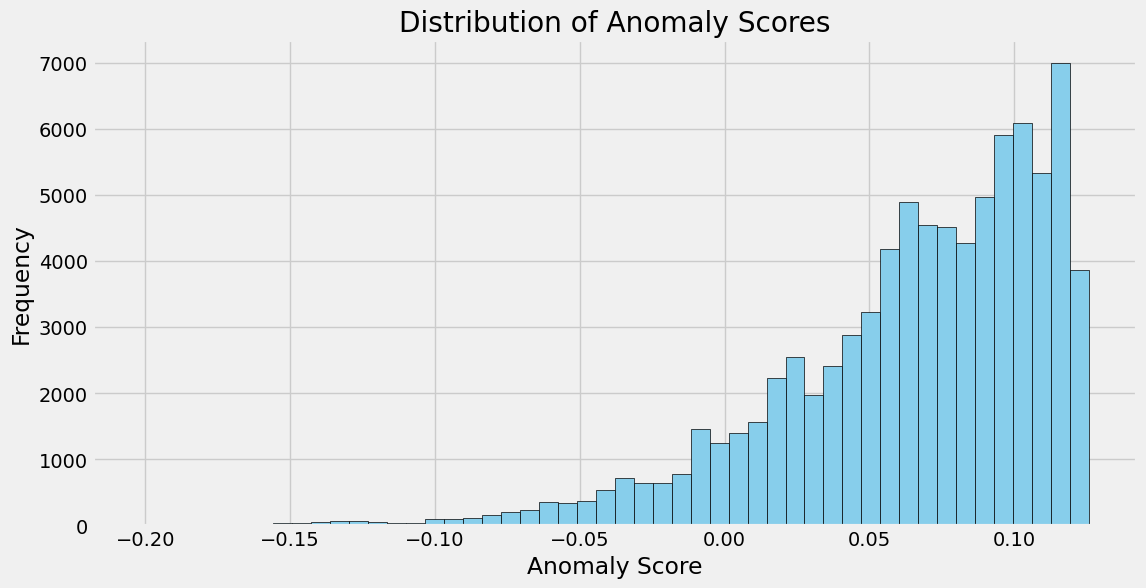

In [22]:
# Additionally, visualize the distribution of anomaly scores.
scores = model.decision_function(scaled_data.drop("anomaly", axis=1))
plt.figure(figsize=(12, 6))
plt.hist(scores, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


### Interpretation:
This evaluation section addresses performance using both quantitative metrics and visual analysis:
- **Quantitative Evaluation:**  
  - If true labels (e.g., `attack_cat` or `label`) are available, they are mapped to a binary format (0 for normal, 1 for anomalies).  
  - The Isolation Forest predictions are similarly converted to binary.  
  - A confusion matrix and a detailed classification report (precision, recall, and F1-score) are generated to assess model performance.
- **Anomaly Score Distribution:**  
  - The decision function provides continuous scores that represent the “normality” of each instance.  
  - A histogram of these scores helps visualize how distinctly the model separates normal points from anomalies.
  
This multi-faceted evaluation offers insights into both the statistical performance and the confidence of the model.


## 8. Key Insights and Conclusion

### Key Insights:
- **Algorithm Understanding:**  
  - Isolation Forest isolates anomalies via random partitioning. Its strength lies in the fact that anomalies are more susceptible to isolation, resulting in shorter average path lengths.
  - The mathematical underpinning, through harmonic averages and path length normalization, provides a robust anomaly score.
  
- **Data Preprocessing Importance:**  
  - Standardizing features ensures equal contribution of all variables and improves model performance.
  - Proper EDA helps in understanding feature relationships and potential class imbalances.

- **Model Performance:**  
  - The contamination parameter is critical and must reflect the expected proportion of anomalies in the data.
  - When ground truth labels are available, standard metrics such as precision, recall, and the confusion matrix are invaluable for performance validation.

### Conclusion:
Isolation Forest is a powerful unsupervised algorithm that is particularly effective for anomaly detection in high-dimensional datasets like UNSW-NB15. Its reliance on random partitioning makes it computationally efficient and robust without needing strong distributional assumptions. However, careful parameter tuning and data preprocessing are essential for optimal performance. The comprehensive evaluation herein demonstrates the method's applicability and the interpretative power of its anomaly scores.

Thank you for exploring this in-depth guide to Isolation Forest for anomaly detection. Continue to experiment with different parameters and additional feature engineering to further enhance the model's performance.
